# Single Cell Sequencing: Gynty's dataset comparison


We want to compare labels from Ginty's dataset with out sequencing data. For that aim we use Sharma's dataset ('GSM4130750_WT_1.csv' file) and we agregate our data into this one that has a label for each cell type. 

## Section I: Loading and quality control of Ginty's dataset

In [1]:
### Reading Sharma, Ginty dataset
import numpy as np
import pandas as pd
import scanpy as sc
import csv
import anndata as ad
import scipy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
data_path = '/home/melma31/Documents/single_cell_sequencing/data/'
file_name = 'GSM4130750_WT_1.csv'

df_genes = []
df_cells = []
df_class = []
count_matrix = np.zeros((11139,20924))
with open(data_path+file_name, 'r') as file:
  csvreader = csv.reader(file)
  count  = 0
  for row in csvreader:
    if count == 0:
      df_class = row
    if count == 1:
      df_cells = row[1:]
    if count > 2:
      df_genes.append(row[0])
      x = [float(row[element]) for element in range(1, len(row))]
      count_matrix[:,count-3] = x
    count+=1

### generate anndata object
adata = ad.AnnData(count_matrix)
adata.obs_names = df_cells
adata.var_names = df_genes

In [3]:
adata.obs['class'] = df_class[1:]

(11139,)
(11139,)


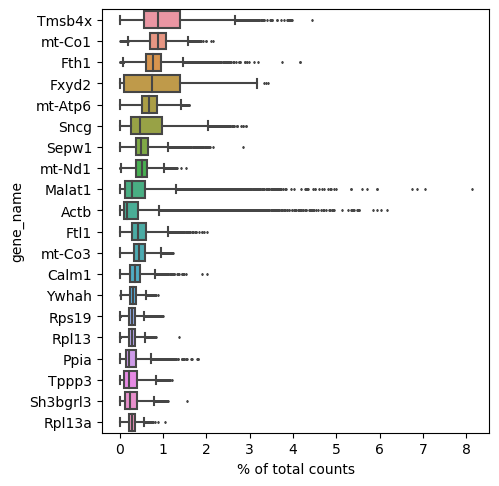

In [4]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(axis = 1)
x =  adata.X.sum(axis = 1)
adata.obs['log_counts'] = np.log(x)
adata.obs['n_genes'] = (adata.X > 0).sum(axis = 1)

adata.var_names_make_unique()
mt_gene_mask = np.flatnonzero([gene.startswith('mt-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
y = np.sum(adata[:, mt_gene_mask].X, axis=1)
z = np.array(adata.obs['n_counts']).reshape(-1,)
print(y.shape)
print(z.shape)
adata.obs['mt_frac'] = y/z


adata.var["gene_name"] = df_genes
adata.var.index = adata.var["gene_name"]

adata.var_names_make_unique()

sc.pl.highest_expr_genes(adata, n_top=20)

adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

mito_genes = adata.var_names.str.startswith('mt-')
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)

adata.obs['n_counts'] = adata.X.sum(axis=1)

In [5]:
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_genes = 1000)
sc.pp.filter_cells(adata, min_genes = 1000)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='cell_ranger')
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

Number of cells after min count filter: 11139

 Number of highly variable genes: 3988


In [6]:
sc.pp.pca(adata, n_comps=25, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.tsne(adata) #Note n_jobs works for MulticoreTSNE, but not regular implementation)

sc.tl.umap(adata)
sc.tl.diffmap(adata)

/home/melma31/mambaforge/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/melma31/mambaforge/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/melma31/mambaforge/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDepreca

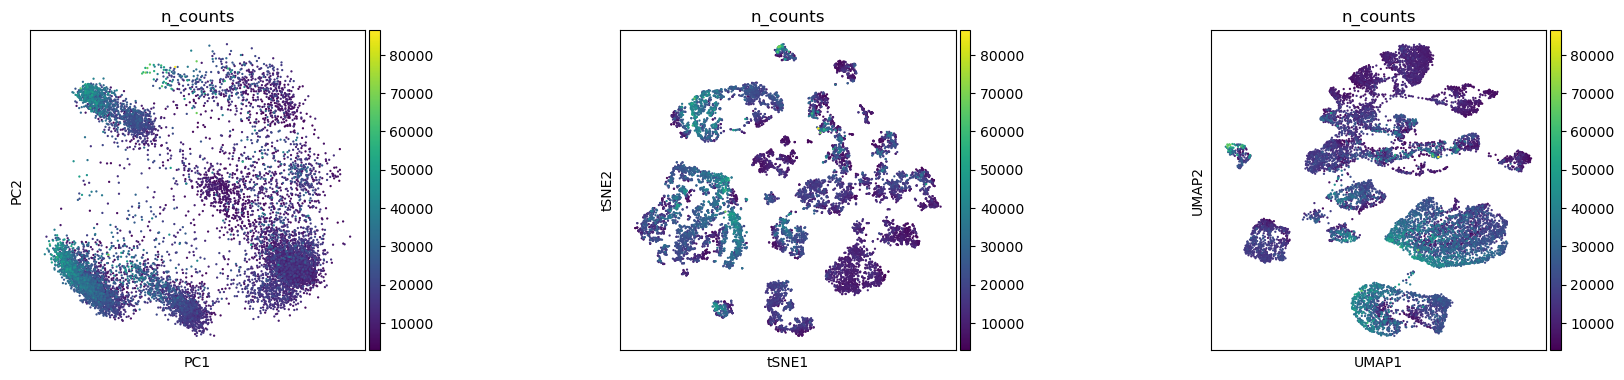

In [9]:
from matplotlib import rcParams
import matplotlib.pylab as plt


rcParams['figure.figsize']=(20,10)
fig_ind=np.arange(231, 237)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p10 = sc.pl.pca_scatter(adata, color='n_counts', ax=fig.add_subplot(fig_ind[0]), show=False)
p11 = sc.pl.tsne(adata, color='n_counts', ax=fig.add_subplot(fig_ind[1]), show=False)
p12 = sc.pl.umap(adata, color='n_counts', ax=fig.add_subplot(fig_ind[2]), show=False)
plt.show()

## Section II: LOAD CAMPARI DATA

In [11]:
figure_path = '/home/melma31/Documents/single_cell_sequencing/figures/'
input_path = '/home/melma31/Documents/single_cell_sequencing/output/'

adata_campari = ad.read_h5ad(input_path + 'campari_scs.h5ad')
sc.pp.normalize_total(adata_campari, target_sum=1e4)
x = adata_campari.X
stim = np.zeros((x.shape[0],))
red = np.zeros((x.shape[0],))
green = np.zeros((x.shape[0],))
louvain = np.zeros((x.shape[0],6))

for i in range(x.shape[0]):
    stim[i] = adata_campari.obs['stimulus'][i]
    red[i] = adata_campari.obs['red'][i]
    green[i] = adata_campari.obs['green'][i]

/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))



 Number of highly variable genes: 5000


In [14]:
var_names = adata.var_names.intersection(adata_campari.var_names)
print(adata_campari.shape)
print(var_names.shape)
print(adata.shape)

(1134, 15000)
(9188,)
(11139, 17958)


In [16]:

# function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

x = unique(var_names)
print(len(x))
#var_names = adata.var_names.intersection(adata_campari.var_names)
adata = adata[:, var_names]
adata_campari = adata_campari[:, var_names]


9188


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

(11139, 9188)

In [ ]:

sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.louvain(adata, resolution=1, key_added='louvain_1')

In [ ]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color=['louvain_1','class'])

In [ ]:
sc.tl.ingest(adata_campari, adata, obs='class')

In [ ]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

labels=['Control','pinch','new_stroke','ballon','AG','AD','heating','mock','old_stroke','anal_pinch','mock_w_poop','vaginal_distension','tomatoe','poop']

colors = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan','magenta','yellow',
          'lime','indigo','tomato','darkkhaki','peru']


unique_classes = unique(df_class)
fraction_cells = np.zeros((len(labels),len(unique_classes)))

for i in range(len(labels)):
    
    index = np.logical_and(adata_campari.obs['stimulus'] == i,adata_campari.obs['red'] >= 0)
    aux_adata = adata_campari[index,:]
    for j in range(len(aux_adata)):
        one_class = aux_adata.obs['class'][j]
        index = unique_classes.index(one_class)
        fraction_cells[i,index] +=1
print(fraction_cells.shape)

In [ ]:
fraction_cells = fraction_cells / np.sum(fraction_cells, axis = 1).reshape(-1,1)

#colors = ['gainsboro','green','darkorange','purple','magenta','cyan','red','orange','yellow','brown',
#         'orange','blue','violet','k']

print(len(unique_classes))
fig, axes = plt.subplots()
cumulative = fraction_cells[:,0] * 0
for i in range(len(unique_classes)):
    axes.bar(np.arange(0,len(labels)),fraction_cells[:,i], bottom = cumulative, color = colors[i],alpha = 0.9)
    cumulative = cumulative + fraction_cells[:,i]

axes.legend(unique_classes)
axes.set_ylim([0,1])
axes.set_xlim([-1,20])
axes.set_xticks(np.arange(0,len(labels)))
xticklabels = axes.set_xticklabels(labels)
axes.set_xticklabels(xticklabels, rotation = 90)

fig.set_size_inches([12,8])
fig.suptitle('Cell class type (Gynty dataset)', fontsize = 15)
fig.savefig(figure_path + 'classification.png')

In [ ]:
adata_concat = adata.concatenate(adata_campari, batch_categories=['ref', 'new'])
sc.pl.umap(adata, color='class', save = 'ginty_clustering.png')
sc.pl.umap(adata_campari, color='class',size = 50, wspace=1, save = 'UMIs/ginty_comparison/data_clustering_into_ginty.png')

In [ ]:
labels=['Control','pinch','stroke','ballon','AG','AD','heating','mock']

for i in range(0,11):
    index = np.logical_and(adata_campari.obs['stimulus'] == i,adata_campari.obs['red'] > 0)
    aux_adata = adata_campari[index,:]
    print(aux_adata.shape)
    sc.pl.umap(aux_adata, size = 50, color = ['class','red'],save = 'UMIs/ginty_comparison/stimulus_ginty_map_' + labels[i]+ '.png')
    #sc.pl.umap(aux_adata, size = 50, color = , color_map = 'Reds',save = 'stimulus_ginty_map_red_' + labels[i]+ '.png')



#sc.pl.umap(adata_campari, color='stimulus', wspace=1)

In [ ]:
sc.pl.umap(adata_concat, color=['batch'], save = 'UMIs/ginty_comparison/ginty_us_overlap.png')